In [38]:
import re
from tqdm.notebook import tqdm

from IPython.display import display

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers

from covid_flu import config, utils, time_series, plotting

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
df_flu = utils.load_flu_data()
display(df_flu.head())
display(df_flu.tail())

,time,wili,state
0,2010-40,2.13477,Alabama
1,2010-41,2.05999,Alabama
2,2010-42,1.94224,Alabama
3,2010-43,2.27650,Alabama
4,2010-44,2.83371,Alabama


,time,wili,state
456,2019-27,0.280899,Wyoming
457,2019-28,0.166021,Wyoming
458,2019-29,0.000100,Wyoming
459,2019-30,0.000100,Wyoming
460,2019-31,0.000100,Wyoming


## Simple RNN model: predicting `d` days from a fixed input length

In [23]:
# Preparing data
HISTORY_SIZE = 25
TARGET_SIZE = 1

X_all, y_all = [], []
for state in df_flu['state'].unique():
    subset = df_flu.query('state == @state')['wili'].values
    ts_len = len(subset)
    for i in range(ts_len - HISTORY_SIZE - TARGET_SIZE):
        hist, trg = time_series.prepare_univariate_time_series(subset, HISTORY_SIZE, TARGET_SIZE, offset=i)
        X_all.append(hist)
        y_all.append(trg)

X_all = np.stack(X_all, axis=0)
y_all = np.concatenate(y_all)

In [24]:
X_all.shape

(22847, 25, 1)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2)

In [26]:
len(X_train), len(X_test)

(18277, 4570)

In [35]:
# Processing with tensorflow
BATCH_SIZE = 256
BUFFER_SIZE = 1000

ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
ds_train = ds_train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

ds_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))
ds_test = ds_test.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

### Constructing the RNN

In [48]:
simple_lstm = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=X_train.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm.compile(optimizer='adam', loss='mse')
simple_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 8)                 320       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


In [49]:
EPOCHS = 50
STEPS_PER_EPOCH = 50
history = simple_lstm.fit(ds_test, epochs=EPOCHS, validation_data=ds_test,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=50)

Train for 50 steps, validate for 50 steps
Epoch 1/50
50/50 [==============================] - 3s 67ms/step - loss: 4.9795 - val_loss: 4.0156
Epoch 2/50
50/50 [==============================] - 1s 22ms/step - loss: 3.4894 - val_loss: 2.9897
Epoch 3/50
50/50 [==============================] - 1s 20ms/step - loss: 2.7255 - val_loss: 2.3671
Epoch 4/50
50/50 [==============================] - 1s 20ms/step - loss: 2.1026 - val_loss: 1.9278
Epoch 5/50
50/50 [==============================] - 1s 20ms/step - loss: 1.8040 - val_loss: 1.6281
Epoch 6/50
50/50 [==============================] - 1s 19ms/step - loss: 1.5088 - val_loss: 1.4375
Epoch 7/50
50/50 [==============================] - 1s 19ms/step - loss: 1.3483 - val_loss: 1.2441
Epoch 8/50
50/50 [==============================] - 1s 20ms/step - loss: 1.2103 - val_loss: 1.1621
Epoch 9/50
50/50 [==============================] - 1s 21ms/step - loss: 1.0996 - val_loss: 1.0593
Epoch 10/50
50/50 [==============================] - 1s 20ms/step -

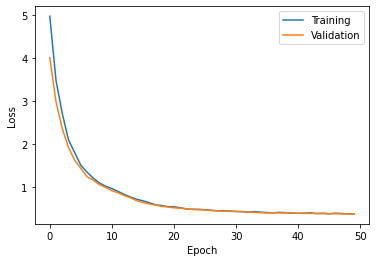

In [50]:
plotting.plot_history(history)

In [58]:
def 

idx_eval = 1000
X_eval = X_test[idx_eval].reshape(1, -1, 1)
y_eval = y_test[idx_eval]
y_pred = simple_lstm.predict(X_eval)

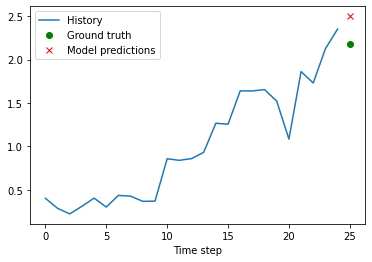

In [63]:
plotting.plot_time_series_prediction(X_eval, y_eval, y_pred)